# Exploratory Analysis of Water Quality Data II - Continuous Data

# Sampling Location

This document includes Python code and results of the exploratory analysis of water quality data in the SEACAR Pilot project.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy      as np
import pandas     as pd
import geopandas  as gpd
import contextily as cx
import seaborn    as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Data loading and preprocessing
Read the csv file and shapefile of managed areas.

In [4]:
df      = pd.read_csv(r"../OEAT_Continuous-2022-Nov-04.csv")
areaShp = gpd.read_file("../GIS_data/ORCP_Managed_Areas_Oct2021.shp")

Select five managed areas and six parameters. Select only columns that are needed for the analysis. Convert the SampleDate from string to datetime object.

In [5]:
df2 = df.loc[df["ManagedAreaName"].isin(["Guana Tolomato Matanzas National Estuarine Research Reserve",
                            "Biscayne Bay Aquatic Preserve",
                            "Estero Bay Aquatic Preserve",
                            "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
                            "Big Bend Seagrasses Aquatic Preserve"])]
df2 = df2[['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
           'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']]
df2 = df2.loc[df2["ParameterName"].isin(["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth","Water Temperature"])]
df2["timestamp"]=  pd.to_datetime(df2['SampleDate'])

Remove outliers

In [6]:
# Remove total nitrogen outliers (>100)
df2.drop(df2[(df2['ParameterName'] == 'Total Nitrogen') & 
    (df2['ResultValue'] > 100)].index,inplace=True)

# Remove a single measurement in 1996-07-22 (RowID: 1582917)
df2.drop(df2[df2['RowID'] == 1582917].index, inplace=True)

# Remove turbidity outliers (>25)
df2.drop(df2[(df2['ParameterName'] == 'Turbidity') & 
    (df2['ResultValue'] > 25)].index, inplace=True)

# Remove Secchi Depth before 1995 (117 records)
df2.drop(df2[(df2['ParameterName'] == 'Secchi Depth') & 
    (df2['Year'] < 1995)].index, inplace=True)

Create lists of water quality parameters, lists of five managed areas and list of statistics to be calculated.

In [7]:
listPara = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth","Water Temperature"] 
listArea = ["Guana Tolomato Matanzas National Estuarine Research Reserve",
                            "Biscayne Bay Aquatic Preserve",
                            "Estero Bay Aquatic Preserve",
                            "Gasparilla Sound-Charlotte Harbor Aquatic Preserve",
                            "Big Bend Seagrasses Aquatic Preserve" ]
listValue = ["count", "mean","max","min","std"]
dictUnits = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m", "Water Temperature": "Degrees C"}
dictMonth = {1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",
             9:"September",10:"October",11:"November",12:"December"}
dictArea = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
            'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
            'Biscayne Bay Aquatic Preserve':'Biscayne Bay'}

## 2. Sampling locations

This step is to calculate histogram of samples at unique locations.


### 2.1 Sample frequencies at unique locations
First, aggregate the data by location and parameter name.

In [70]:
plt.rcParams['figure.figsize'] = [16, 8]

dfLoc  = df2.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName","ProgramLocationID"])["ResultValue"].agg("count").reset_index()

dfLoc = dfLoc.rename(columns={"ResultValue": "samples"})

dfLoc.loc[dfLoc["samples"] == 1,['sample_type']] ='Random Point'
dfLoc.loc[dfLoc["samples"] > 1,['sample_type']] ='Fixed Point'

# print unique locations and frequencies
display(df2.groupby(['Latitude_DD', 'Longitude_DD']).size().reset_index(name='Freq'))

Latitude_DD  Longitude_DD     Freq
0     25.758020    -80.167690    58905
1     25.769800    -80.180850    62237
2     25.777300    -80.204000   160092
3     25.821730    -80.151250   445149
4     25.830030    -80.158600   289246
5     25.846841    -80.182861   358201
6     26.355000    -81.844500  1930694
7     26.385900    -81.846300  1797685
8     26.434900    -81.911400  2144320
9     26.449685    -81.871465   131390
10    26.743833    -82.060028      387
11    26.755333    -82.059472      381
12    29.101817    -83.076467   637724
13    29.204134    -82.769001     1131
14    29.281351    -83.111237      215
15    29.287817    -83.166083   815487
16    29.489681    -82.976791     1459
17    29.647203    -83.421196   146688
18    29.667071    -81.257403  2143189
19    29.737041    -81.245953  2417314
20    29.813933    -83.628917   915783
21    29.868851    -81.307428  2280567
22    29.994720    -81.329560    70391
23    30.050857    -81.367465  1744304
24    30.301316    -83.979608     1371

Plot histograms of samples at unique positions.

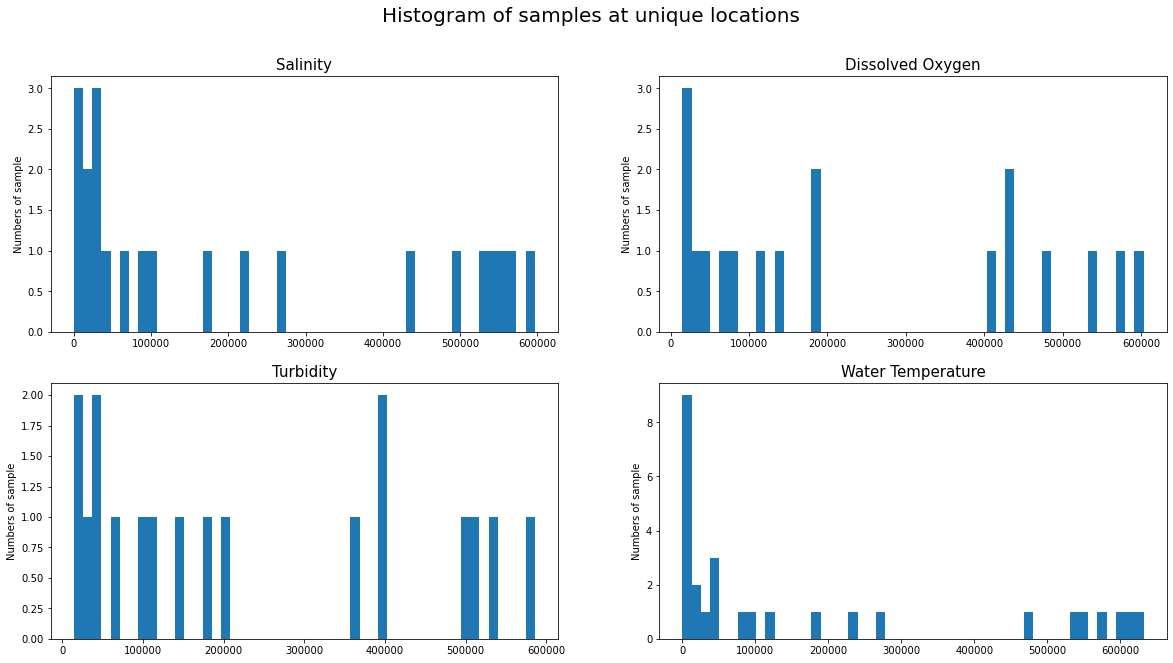

In [9]:
plt.rcParams['figure.figsize'] = [20, 16]

i = 0

fig = plt.figure()
plt.suptitle("Histogram of samples at unique locations", fontsize = 20, y = 0.94)

for para in listPara:
    dfNew = dfLoc[dfLoc['ParameterName']==para]
    if dfNew["ParameterName"].count() != 0:
        ax = fig.add_subplot(3,2,i+1)
        ax.set_title(para, size=15) # Title  
        ax.hist(dfNew["samples"],bins=50)
        i=i+1
        plt.ylabel("Numbers of sample")

## 3 Spatial distribution of sampling locations

Convert sampling points of salinity to GeoDataFrame

In [52]:
# Group data by location, parametername and managed area name
gdfLoc = gpd.GeoDataFrame(dfLoc, geometry = gpd.points_from_xy(dfLoc.Longitude_DD, dfLoc.Latitude_DD), crs="EPSG:4326").to_crs("EPSG:32617")

Plot sampling locations in all years.

Station maps are shown as followed.

In [53]:
dfID  = pd.DataFrame(df2.groupby(["ProgramLocationID","Longitude_DD","Latitude_DD","ManagedAreaName"]).sum().reset_index())
dfID  = dfID[["ProgramLocationID","Longitude_DD","Latitude_DD","ManagedAreaName"]]
gdfID = gpd.GeoDataFrame(dfID, geometry = gpd.points_from_xy(dfID.Longitude_DD, dfID.Latitude_DD), crs="EPSG:4326").to_crs("EPSG:32617")

ProgramLocationID  Longitude_DD  Latitude_DD  \
0           02293252    -82.060028    26.743833   
1           02293254    -82.059472    26.755333   
2           02313700    -82.769001    29.204134   
3           02323566    -82.976791    29.489681   
4           02326526    -83.979608    30.301316   
5            2313700    -82.769001    29.204134   
6            2323566    -82.976791    29.489681   
7            2326526    -83.979608    30.301316   
8    291652083064100    -83.111237    29.281351   
9           872-0494    -81.329560    29.994720   
10            BBBB14    -80.158600    25.830030   
11           BBCWA4     -80.167690    25.758020   
12            BBJT71    -80.151250    25.821730   
13            BBLR03    -80.182861    25.846841   
14            BBMRDW    -80.204000    25.777300   
15            BBMRRB    -80.180850    25.769800   
16             BBSDB    -83.628917    29.813933   
17             BBSSK    -83.076467    29.101817   
18             BBSST    -83.421196    29.647203   
19             BBSSW    -83.166083    29.287817   
20              EB01    -81.911400    26.434900   
21              EB02    -81.846300    26.385900   
22              EB03    -81.844500    26.355000   
23              EB04    -81.871465    26.449685   
24           gtmfmwq    -81.245953    29.737041   
25           gtmpcwq    -81.257403    29.667071   
26           gtmpiwq    -81.367465    30.050857   
27           gtmsswq    -81.307428    29.868851   

                                      ManagedAreaName  \
0   Gasparilla Sound-Charlotte Harbor Aquatic Pres...   
1   Gasparilla Sound-Charlotte Harbor Aquatic Pres...   
2                Big Bend Seagrasses Aquatic Preserve   
3                Big Bend Seagrasses Aquatic Preserve   
4                Big Bend Seagrasses Aquatic Preserve   
5                Big Bend Seagrasses Aquatic Preserve   
6                Big Bend Seagrasses Aquatic Preserve   
7                Big Bend Seagrasses Aquatic Preserve   
8                Big Bend Seagrasses Aquatic Preserve   
9   Guana Tolomato Matanzas National Estuarine Res...   
10                      Biscayne Bay Aquatic Preserve   
11                      Biscayne Bay Aquatic Preserve   
12                      Biscayne Bay Aquatic Preserve   
13                      Biscayne Bay Aquatic Preserve   
14                      Biscayne Bay Aquatic Preserve   
15                      Biscayne Bay Aquatic Preserve   
16               Big Bend Seagrasses Aquatic Preserve   
17               Big Bend Seagrasses Aquatic Preserve   
18               Big Bend Seagrasses Aquatic Preserve   
19               Big Bend Seagrasses Aquatic Preserve   
20                        Estero Bay Aquatic Preserve   
21                        Estero Bay Aquatic Preserve   
22                        Estero Bay Aquatic Preserve   
23                        Estero Bay Aquatic Preserve   
24  Guana Tolomato Matanzas National Estuarine Res...   
25  Guana Tolomato Matanzas National Estuarine Res...   
26  Guana Tolomato Matanzas National Estuarine Res...   
27  Guana Tolomato Matanzas National Estuarine Res...   

                          geometry  
0   POINT (394588.278 2958501.777)  
1   POINT (394654.135 2959775.133)  
2   POINT (328024.626 3231897.863)  
3   POINT (308355.432 3263867.888)  
4   POINT (213431.924 3355936.051)  
5   POINT (328024.626 3231897.863)  
6   POINT (308355.432 3263867.888)  
7   POINT (213431.924 3355936.051)  
8   POINT (294900.564 3241006.315)  
9   POINT (468212.930 3318245.988)  
10  POINT (584328.048 2857130.751)  
11  POINT (583467.390 2849150.001)  
12  POINT (585070.657 2856216.272)  
13  POINT (581884.848 2858977.205)  
14  POINT (579813.031 2851262.712)  
15  POINT (582139.488 2850446.336)  
16  POINT (245929.970 3301067.183)  
17  POINT (297927.294 3221047.556)  
18  POINT (265623.814 3282144.162)  
19  POINT (289584.445 3241820.286)  
20  POINT (409125.347 2924169.498)  
21  POINT (415581.033 2918698.058)  
22  POINT (415738.

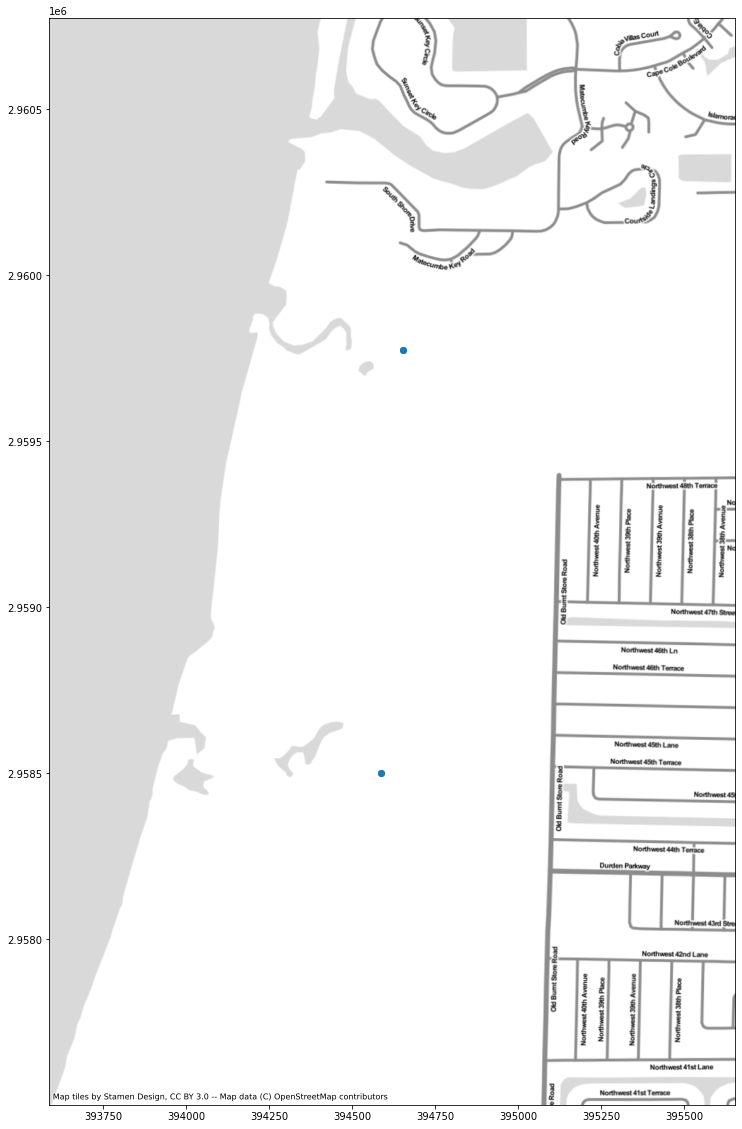

In [56]:
fig, ax = plt.subplots(figsize=(20, 20))


ch = gdfLoc[gdfLoc["ManagedAreaName"] == "Gasparilla Sound-Charlotte Harbor Aquatic Preserve"]

x1, y1, x2, y2 = ch.total_bounds
#extent = (x1-0.005,x2+0.005,y1-0.001,y2+0.001)
extent = (x1-1000,x2+1000,y1-1000,y2+1000)

ch.plot(ax = ax)
ax.axis(extent)
cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite,crs=ch.crs)

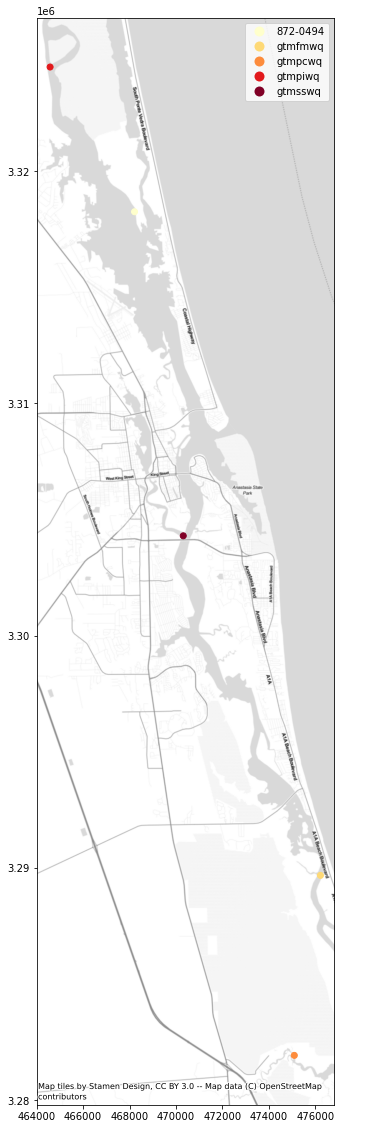

In [80]:
fig, ax = plt.subplots(figsize=(20, 20))



gdfMap.plot(ax = ax, column ='ProgramLocationID',cmap="YlOrRd",legend=True)


cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite,crs=gdfMap.crs)

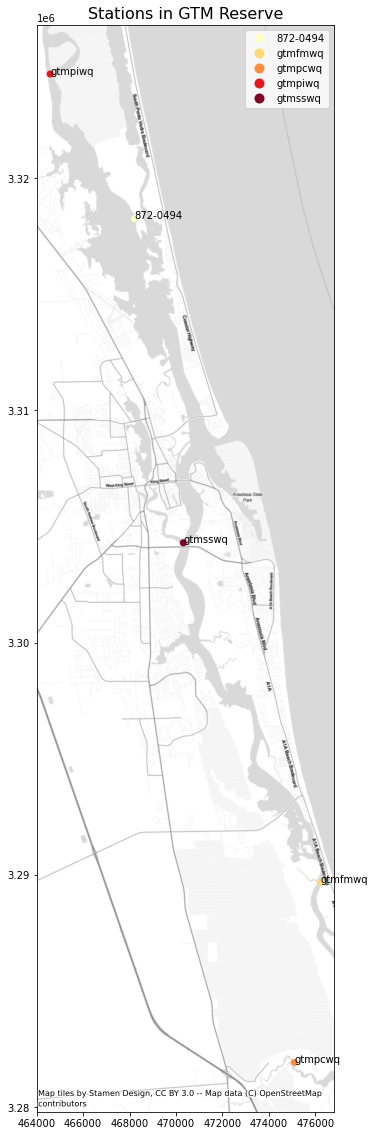

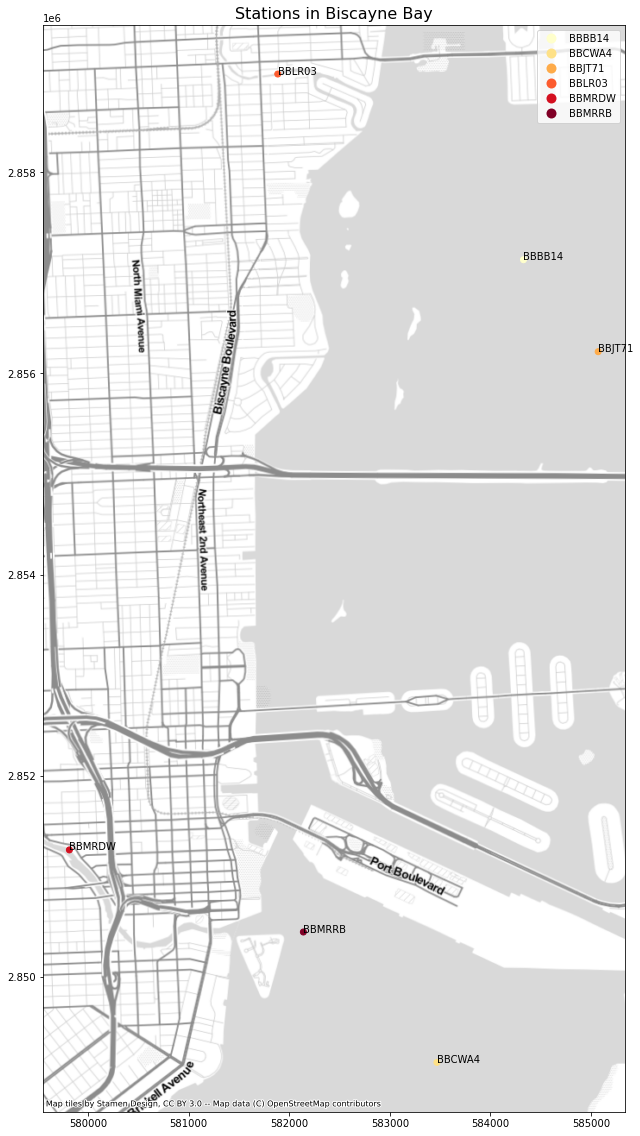

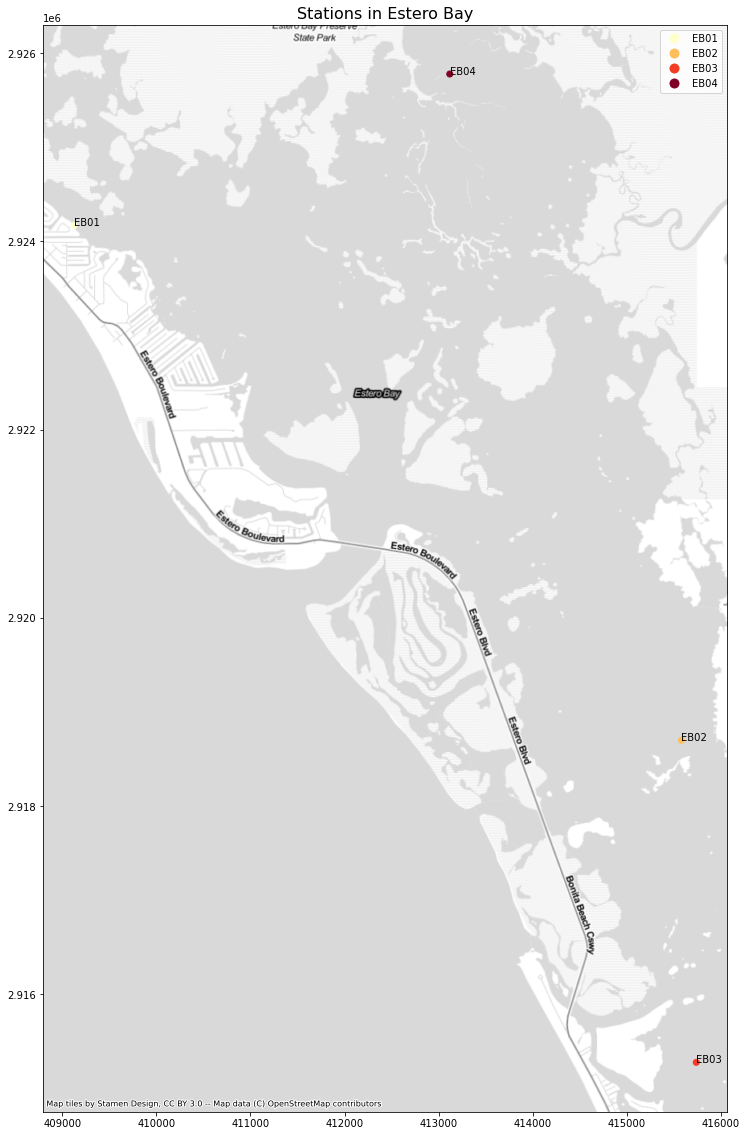

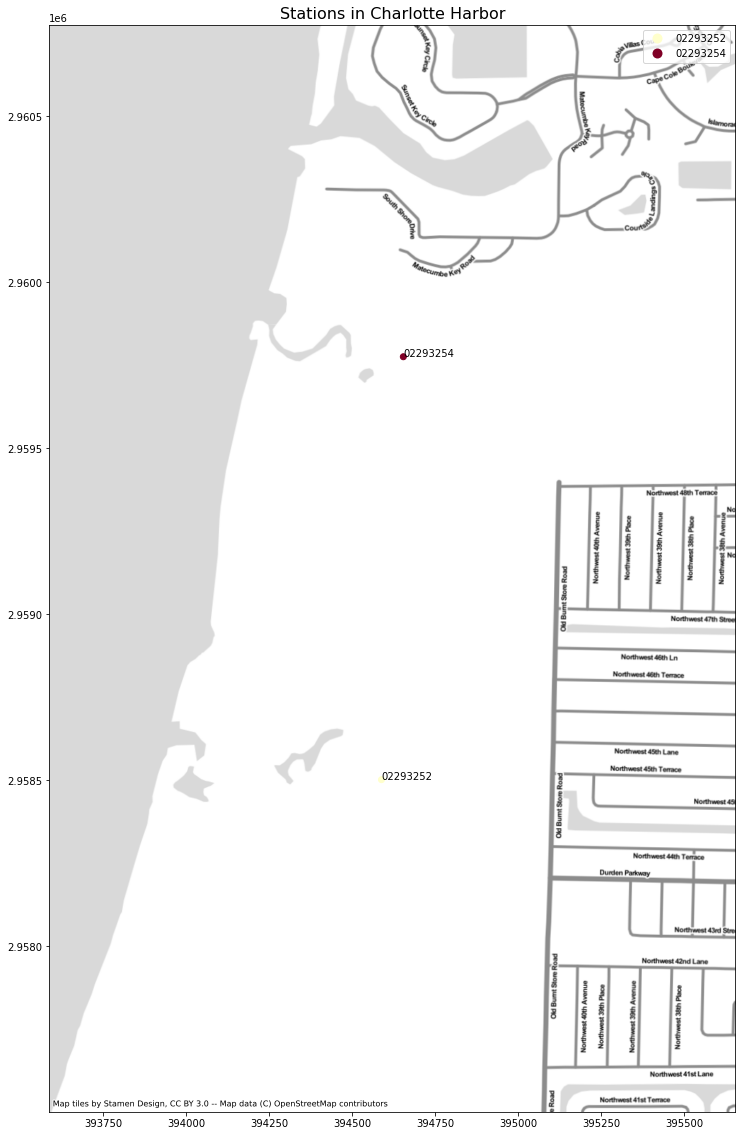

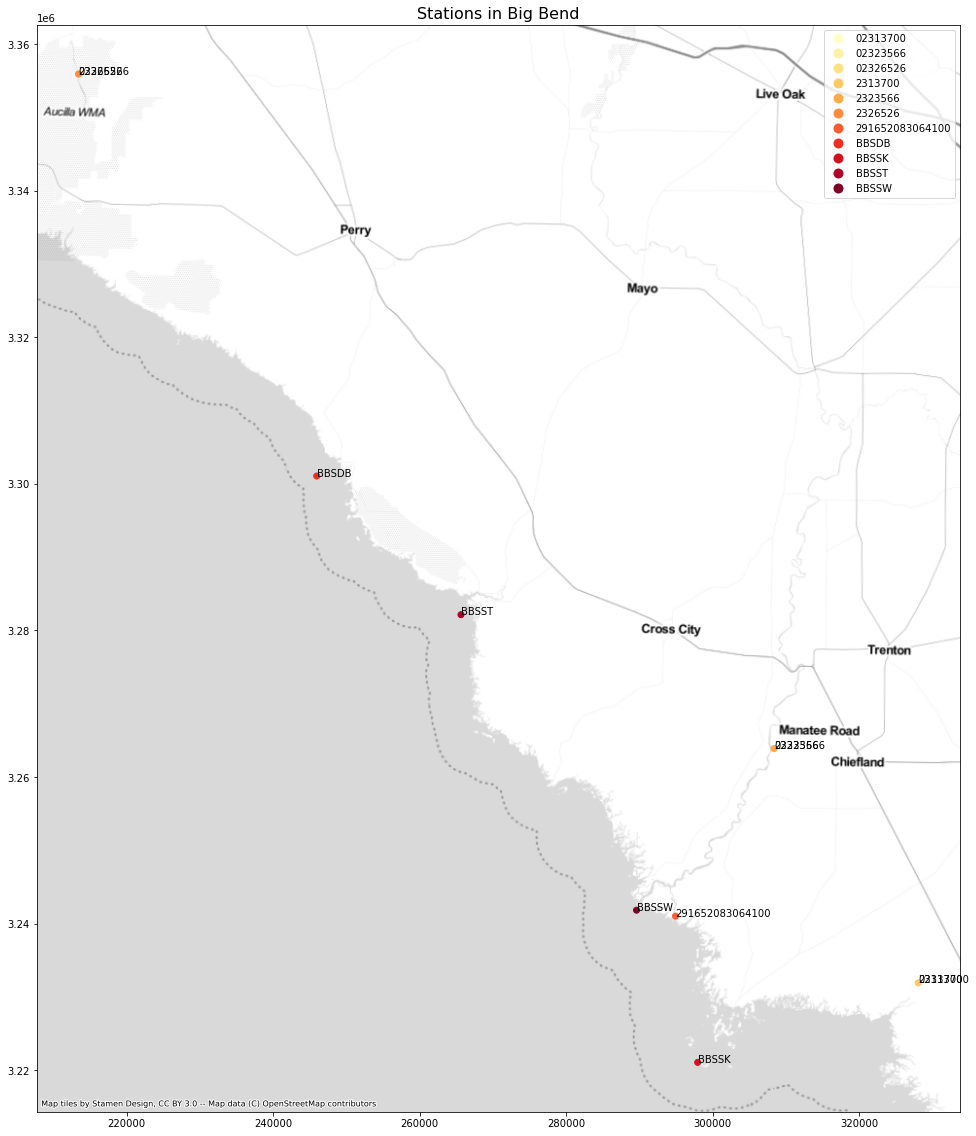

In [92]:
plt.rcParams['figure.figsize'] = [20, 20]

for area in listArea:
    gdfMap = gdfID[gdfID["ManagedAreaName"] == area]
    X = list(gdfMap.geometry.x)
    Y = list(gdfMap.geometry.y)
    Name = list(gdfMap.ProgramLocationID)
    ax = gdfMap.plot(column ='ProgramLocationID',cmap="YlOrRd",legend=True)
    ax.set_title("Stations in {}".format(str(dictArea[area])),size=16)
    for i in range(len(Name)):
        plt.annotate(text=Name[i],xy=(X[i],Y[i]),annotation_clip=False)
    
    # Solve the error of Charlotte Harbor
    if area == "Gasparilla Sound-Charlotte Harbor Aquatic Preserve":
        x1, y1, x2, y2 = ch.total_bounds
        #extent = (x1-0.005,x2+0.005,y1-0.001,y2+0.001)
        extent = (x1-1000,x2+1000,y1-1000,y2+1000)
        ax.axis(extent)
        
    cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite,crs=gdfMap.crs)
    i = 0

### 3.1 Sampling locations of dissolved oxygen in all years

<Figure size 1440x1080 with 0 Axes>

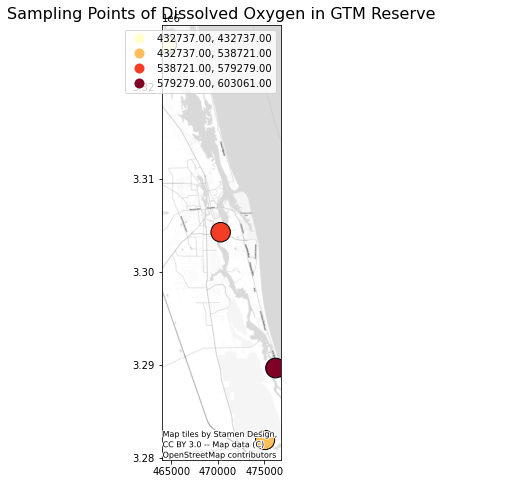

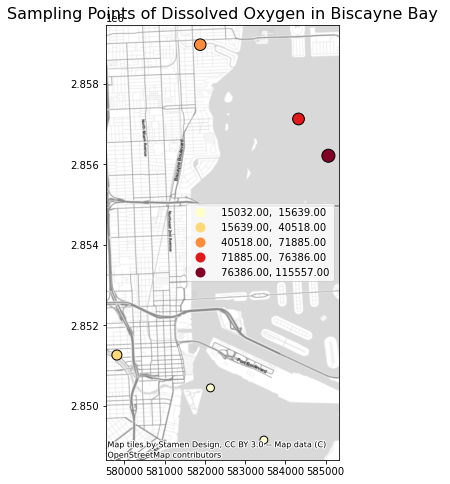

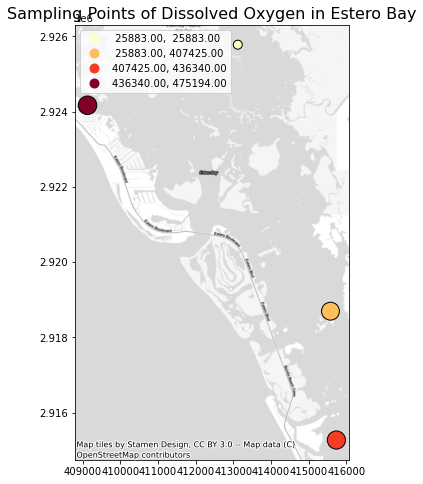

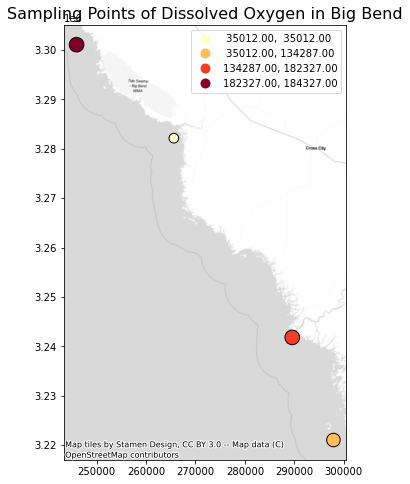

In [72]:
# select parameter and year
para = 'Dissolved Oxygen'

gdfLocPara = gdfLoc[gdfLoc['ParameterName']==para]

fig = plt.figure(figsize = (20, 15))

# This step is to depict the figure about fixed points and random points in each area.
for area in listArea:
    areaPoint = gdfLocPara[gdfLocPara["ManagedAreaName"] == area]
    if areaPoint["ParameterName"].count() != 0:
        #ax = areaPoint.plot(marker="o",facecolors='none', edgecolors='r',markersize=areaPoint['samples'])
        ax = areaPoint.plot(column ='samples',k=5,cmap="YlOrRd", scheme = 'NaturalBreaks',legend=True,
                           marker="o",facecolors='none', edgecolors='black'
                            ,markersize=areaPoint['samples']**(1/2)*0.5
                           )
        ax.set_title("Sampling Points of {} in {}".format(para,str(dictArea[area])),size=16)
        cx.add_basemap(ax,source=cx.providers.Stamen.TonerLite,crs=areaPoint.crs)
        #cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,crs=gdf_Salinity.crs)


### 3.2 Spatial distribution of sampling locations of Dissolved Oxygen in 2019

First, aggregate data by location, parameter name, managed area, year and month.

In [14]:
# Aggregate data
dfLoc_m  = df2.groupby(['Latitude_DD','Longitude_DD',"ParameterName","ManagedAreaName","Year","Month"])["ResultValue"].agg("count").reset_index()

dfLoc_m = dfLoc_m.rename(columns={"ResultValue": "samples"})

dfLoc_m.loc[dfLoc_m["samples"] == 1,['sample_type']] ='Random Point'
dfLoc_m.loc[dfLoc_m["samples"] > 1,['sample_type']] ='Fixed Point'

# Convert the data to GeoDataFrame
gdfLoc_m = gpd.GeoDataFrame(dfLoc_m, geometry = gpd.points_from_xy(dfLoc_m.Longitude_DD, dfLoc_m.Latitude_DD),crs="EPSG:4326")

Plot fixed and random sampling location in each managed aera

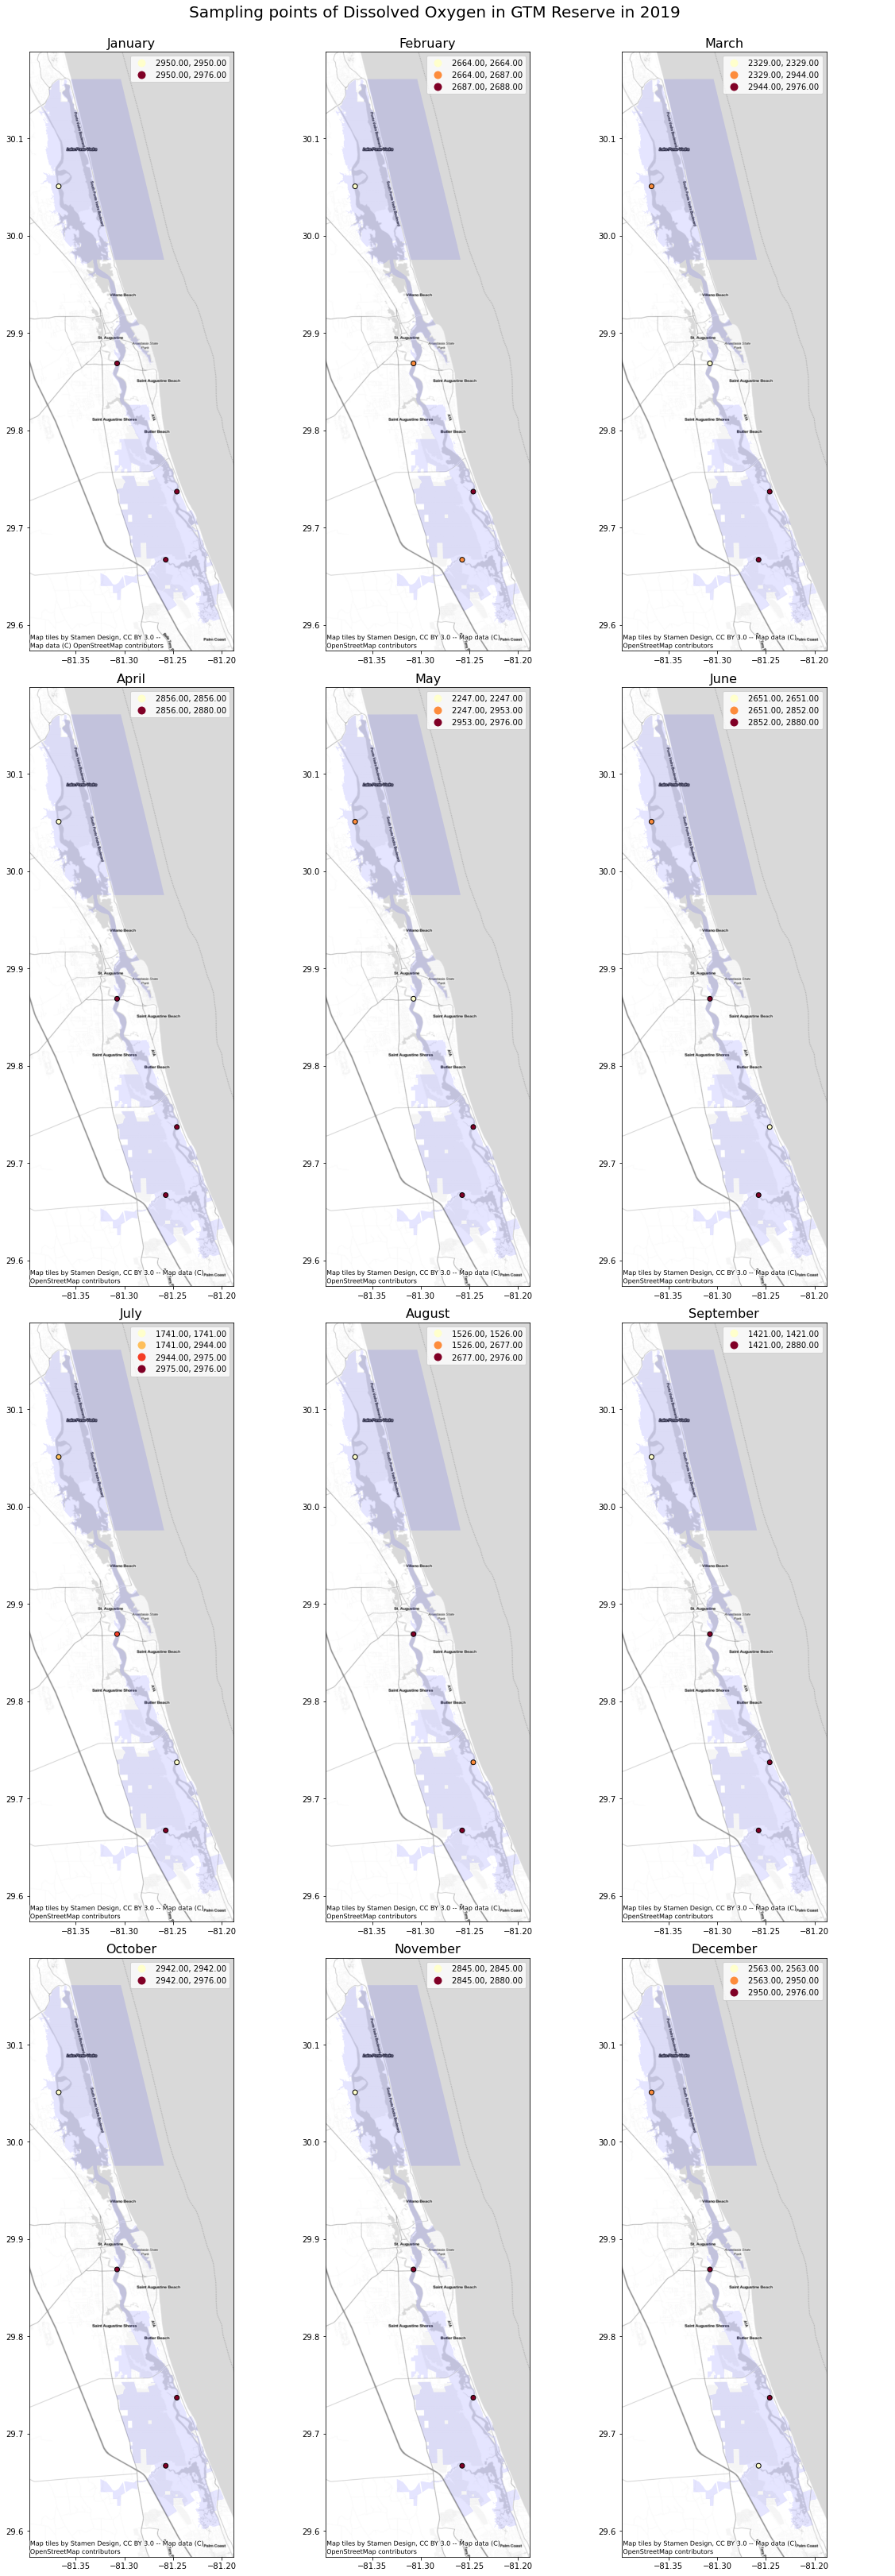

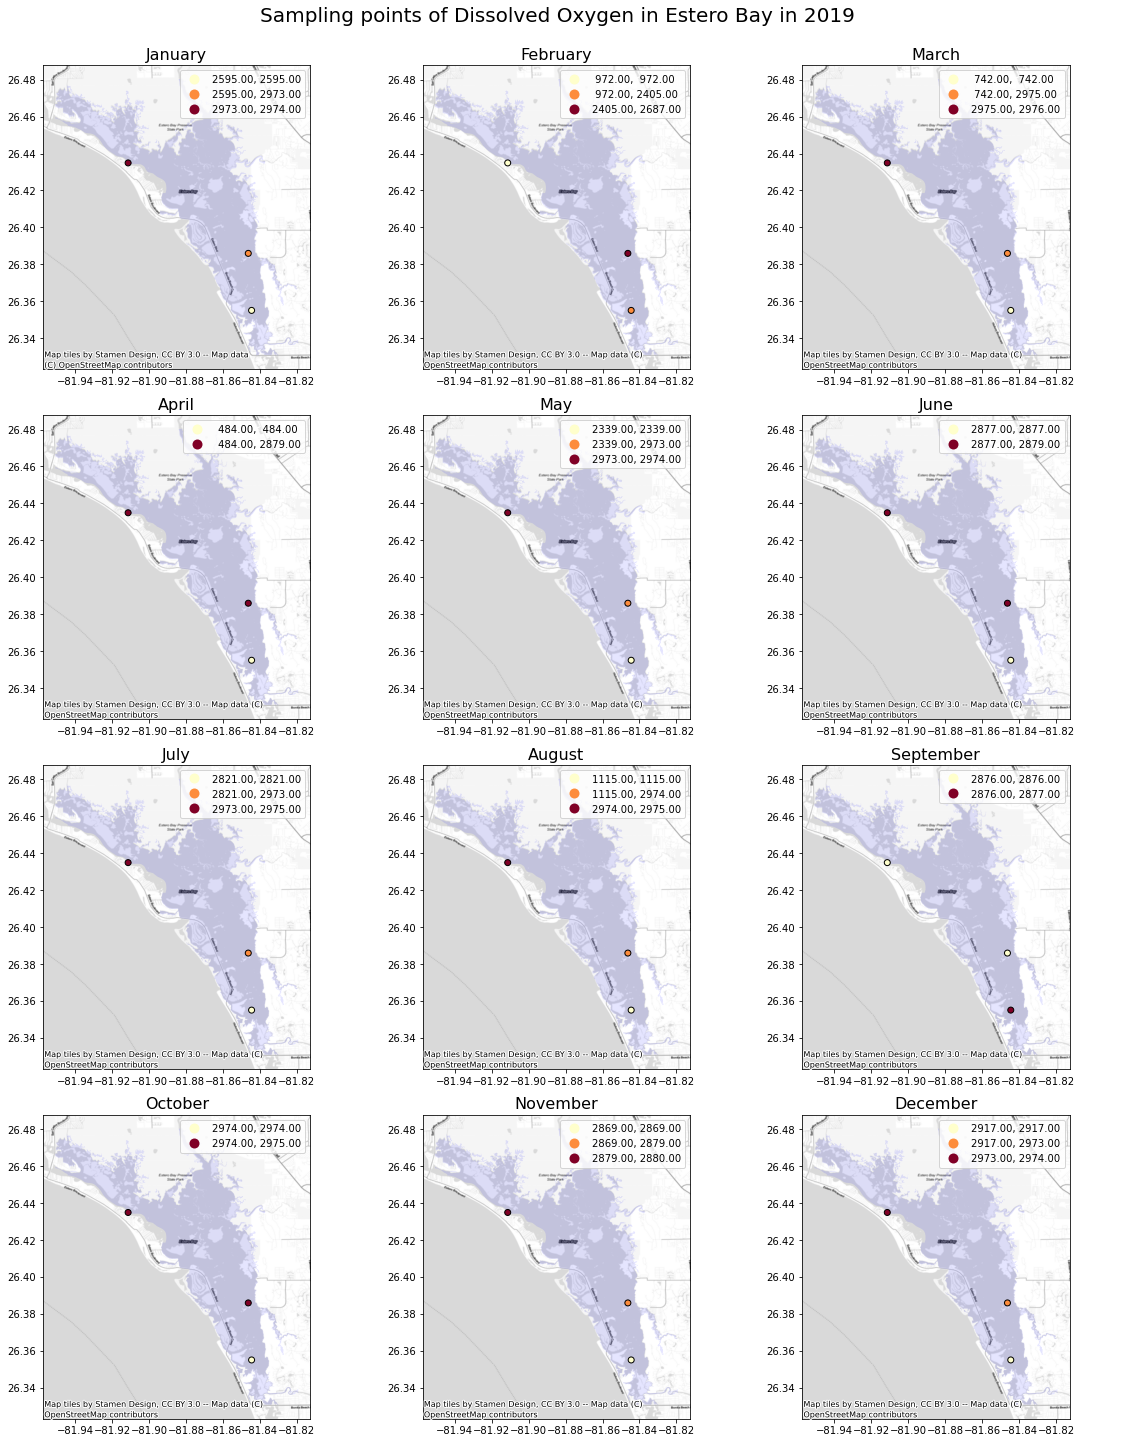

In [15]:
# Select Year and Parameter for the mapping
para, year = 'Dissolved Oxygen', 2019
for area in [listArea[0],listArea[2]]:
#    area = listArea[1]
    
    gdfLocPara = gdfLoc_m[(gdfLoc_m['ParameterName']==para)&(gdfLoc_m["Year"]==year)&(gdfLoc_m["ManagedAreaName"]==area)]
    areaSelect = areaShp[areaShp["LONG_NAME"]==area]

    
    row, col = 4, 3
    fig, axs = plt.subplots(row,col)
    plt.suptitle("Sampling points of {} in {} in {}".format(para, dictArea[area], year), fontsize = 20, y = 1)
    
    if dictArea[area] == 'GTM Reserve' or dictArea[area] == 'Biscayne Bay':
        fig.set_size_inches(16,45)
    else:
        fig.set_size_inches(16,20)
    
    i= 1 
    for r in range(0,row):
        for c in range(0,col):
            # Plot polygon of managed area
            areaSelect.plot(facecolor='blue',edgecolor='none',alpha = 0.1,ax=axs[r,c])
            # Select points by month
            areaPoint = gdfLocPara[gdfLocPara["Month"]==i]
#             print(str(areaPoint["ParameterName"].count())+" "+area)
            if areaPoint["ParameterName"].count() != 0:
                areaPoint.plot(column = 'samples' , k = 5, cmap = "YlOrRd", 
                               scheme = 'natural_breaks', marker = "o",
    #                            markersize=areaPoint['samples']**(1)*32,
                               edgecolors='black', legend=True,ax=axs[r,c])
                axs[r,c].set_title(dictMonth[i],size=16)

                cx.add_basemap(axs[r,c],source=cx.providers.Stamen.TonerLite,crs="EPSG:4326")
                plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=0, wspace=0)
                plt.tight_layout()

                plt.show

                if i > 12:
                    break
                else:
                    i = i+1

### 3.3 Sampling locations of Salinity in managed areas in 2019

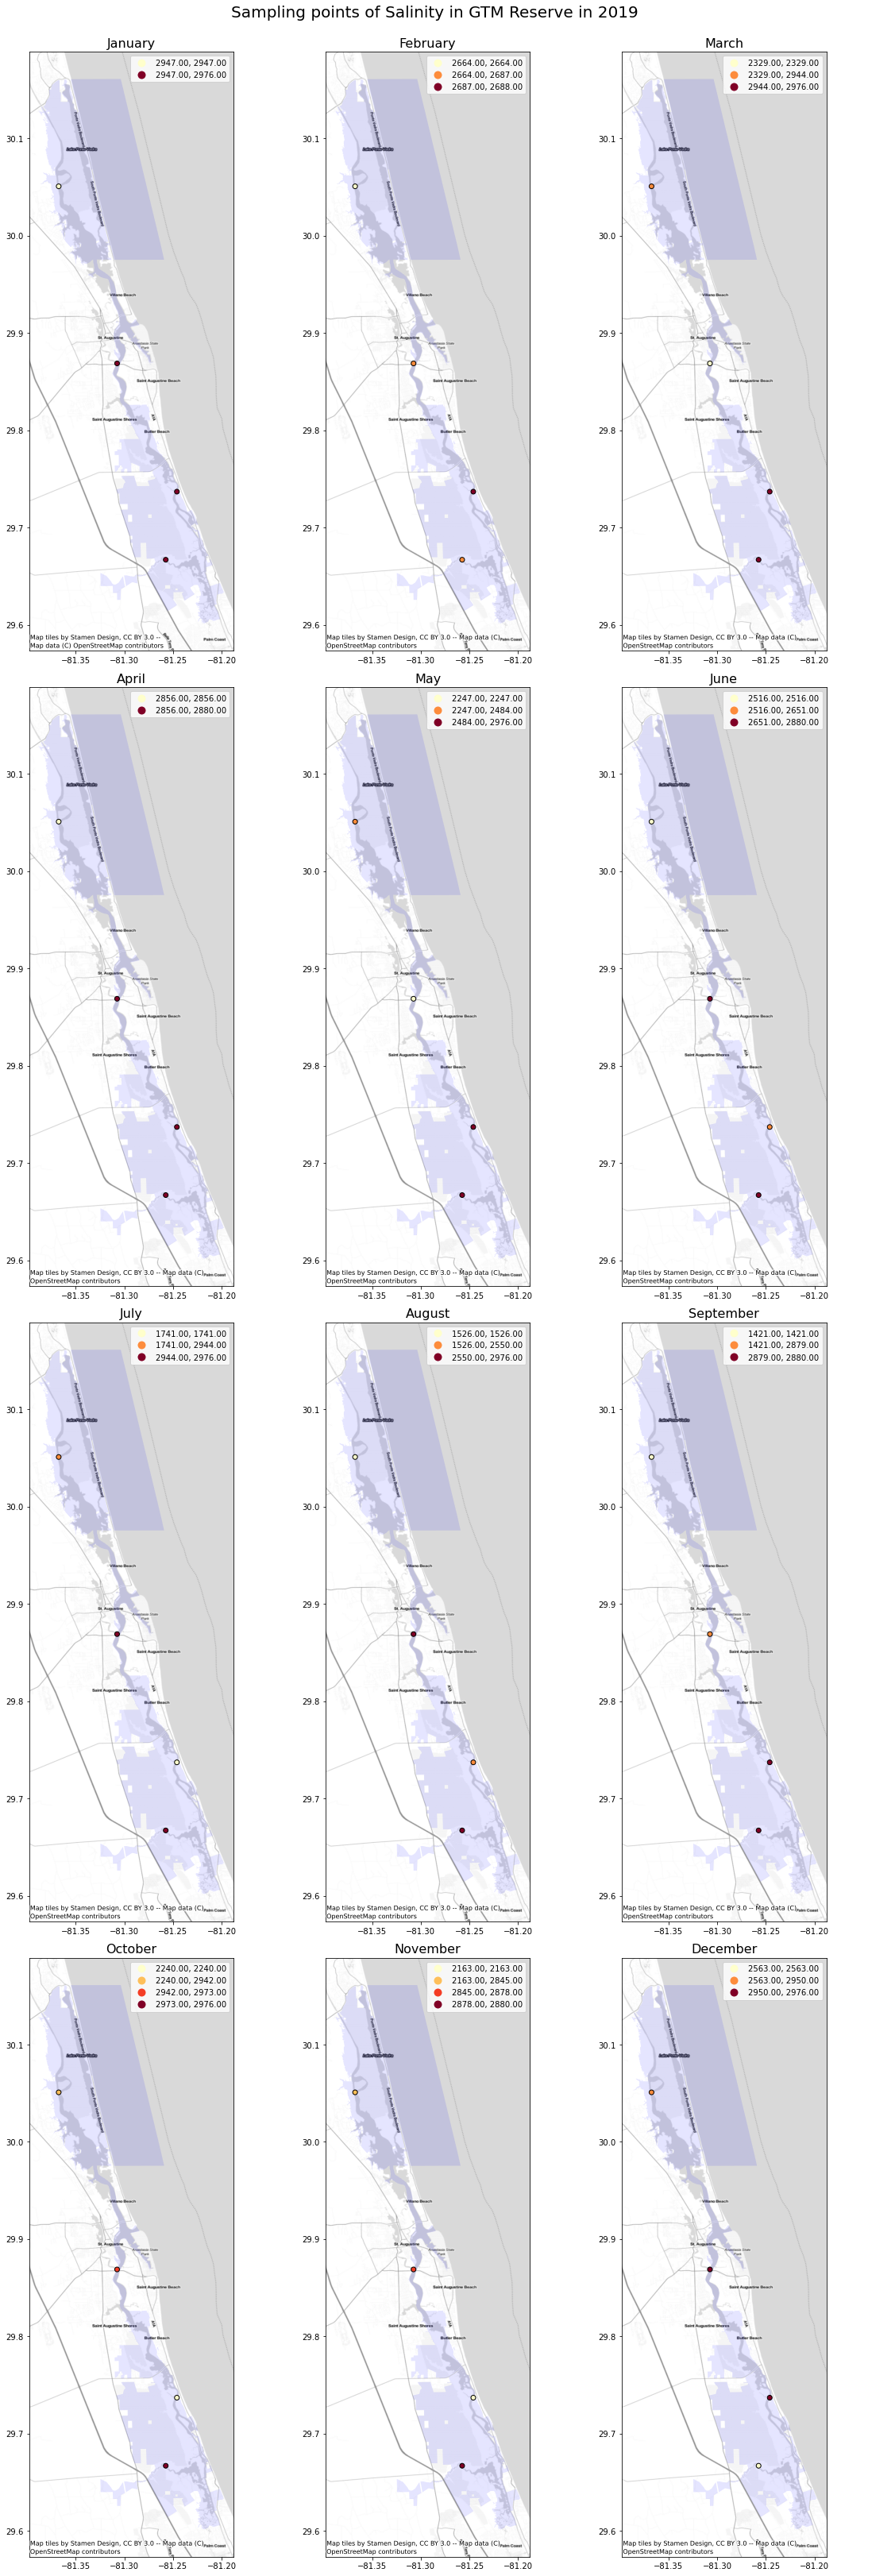

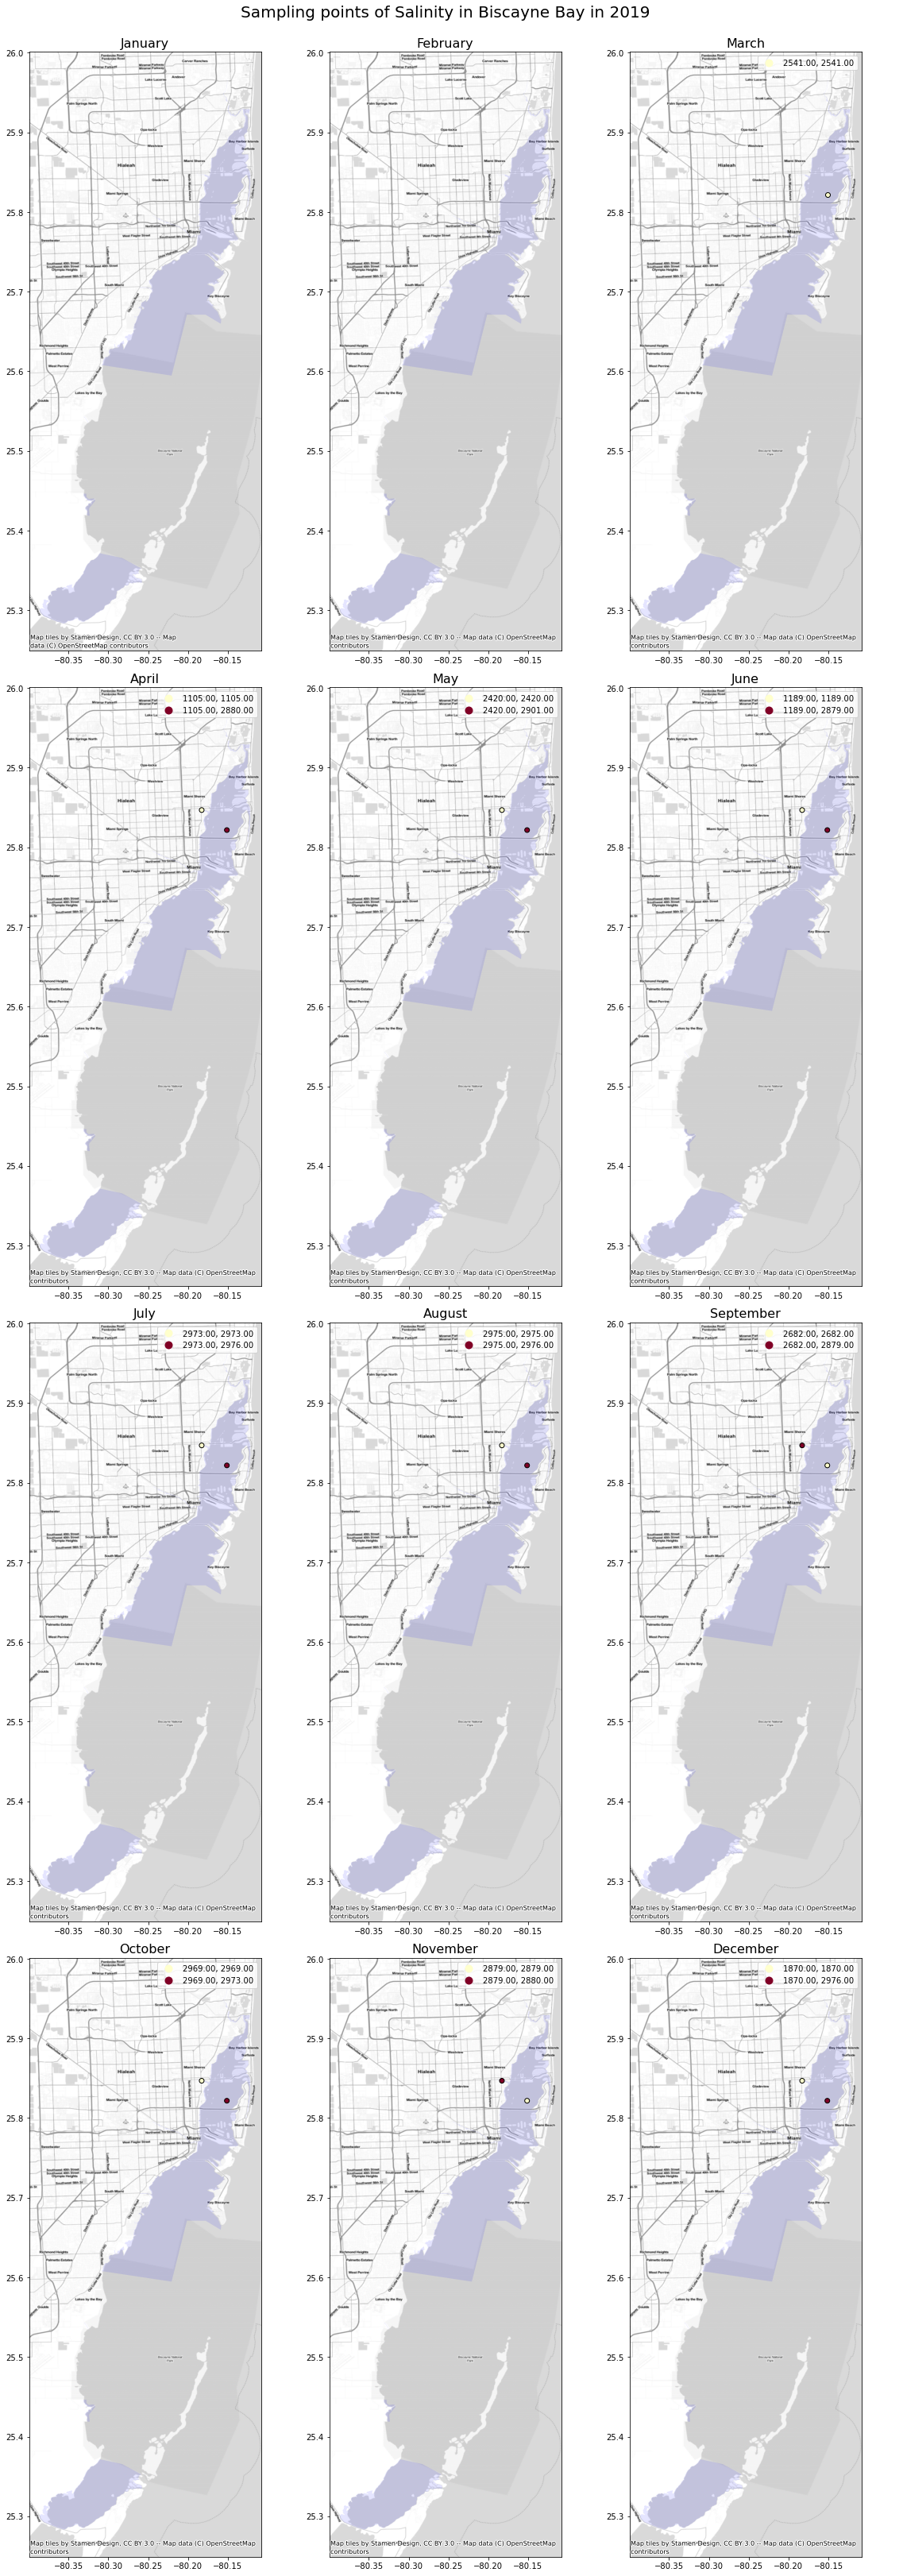

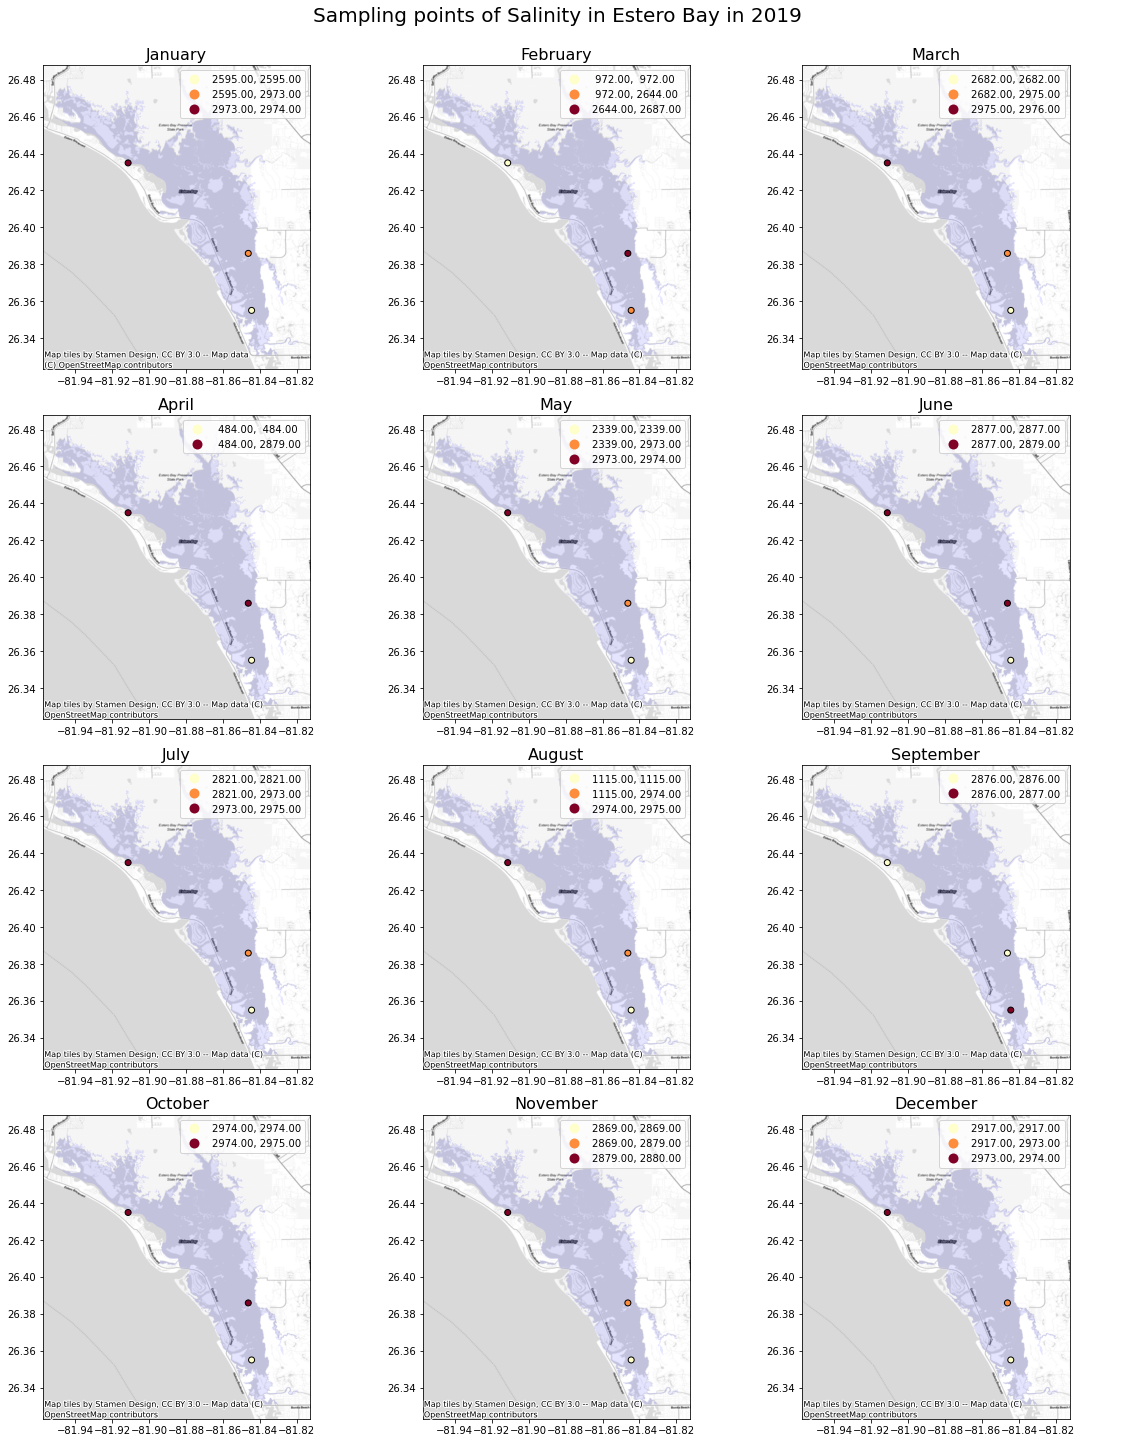

In [16]:
# Select Year and Parameter for the mapping
para, year = 'Salinity', 2019
for area in listArea[0:3]:
#    area = listArea[1]
    
    gdfLocPara = gdfLoc_m[(gdfLoc_m['ParameterName']==para)&(gdfLoc_m["Year"]==year)&(gdfLoc_m["ManagedAreaName"]==area)]
    areaSelect = areaShp[areaShp["LONG_NAME"]==area]

    row, col = 4, 3
    fig, axs = plt.subplots(row,col)
    plt.suptitle("Sampling points of {} in {} in {}".format(para, dictArea[area],year), fontsize = 20, y = 1)
    
    # Choose different layout for different managed areas
    if dictArea[area] == 'GTM Reserve' or dictArea[area] == 'Biscayne Bay':
        fig.set_size_inches(16,45)
    else:
        fig.set_size_inches(16,20)
    
    i= 1 
    for r in range(0,row):
        for c in range(0,col):
            # Plot polygon of managed area
            areaSelect.plot(facecolor='blue',edgecolor='none',alpha = 0.1,ax=axs[r,c])
            # Select points by month
            areaPoint = gdfLocPara[gdfLocPara["Month"]==i]
            
            areaPoint.plot(column = 'samples' , k = 5, cmap = "YlOrRd", 
                           scheme = 'natural_breaks', marker = "o",
#                            ,markersize=areaPoint['samples']**(1)*32,
                           edgecolors='black', legend=True,ax=axs[r,c])
            axs[r,c].set_title(dictMonth[i],size=16)

            cx.add_basemap(axs[r,c],source=cx.providers.Stamen.TonerLite,crs="EPSG:4326")
            plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=0, wspace=0)
            plt.tight_layout()
            
            plt.show

            if i > 12:
                break
            else:
                i = i+1